# Evaluating Logistic Regression Predictions

In [1]:
import os

# Change the current working directory
os.chdir('files')

DATASET: https://www.kaggle.com/datasets/missionjee/car-sales-report

In [2]:
# Import Necessary Libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# and numpy
np.set_printoptions(suppress=True, precision=5)

In [3]:
# Load the labeled dataset of tweets 
df = pd.read_csv('car_data.csv',low_memory=False)

### Part a): Data Cleaning & Exploration


In [4]:
# Drop incomplete records
df = df.dropna(axis = 0)
df = df[['Gender','Annual Income', 'Transmission','Color','Body Style']]

In [5]:
# Transform gender to binary
df['gender-binary'] = np.where(df['Gender'] == 'Female', 1, 0)

In [6]:
# Filter rows where 'gender-binary' is 1
cars = df[df['gender-binary'] == 1]

# Sample 10 random rows
random_rows = cars.sample(n=10, random_state=np.random.RandomState())

# Iterate through the selected rows and print each one in full
for row in random_rows.iterrows():
    print(f"row {row} \n")

row (20890, Gender               Female
Annual Income         13500
Transmission           Auto
Color            Pale White
Body Style        Passenger
gender-binary             1
Name: 20890, dtype: object) 

row (13155, Gender               Female
Annual Income        340000
Transmission         Manual
Color            Pale White
Body Style        Hatchback
gender-binary             1
Name: 13155, dtype: object) 

row (9592, Gender           Female
Annual Income    790000
Transmission       Auto
Color             Black
Body Style          SUV
gender-binary         1
Name: 9592, dtype: object) 

row (23280, Gender               Female
Annual Income       2450000
Transmission           Auto
Color            Pale White
Body Style        Hatchback
gender-binary             1
Name: 23280, dtype: object) 

row (14845, Gender               Female
Annual Income        450000
Transmission         Manual
Color            Pale White
Body Style            Sedan
gender-binary             1
Name: 

#### vi. Concatenate the clean variables into a new dataframe called `X`.


In [7]:
# Categorical variables to matrix
scaler = StandardScaler()
body_style = pd.get_dummies(df['Body Style'])
color = pd.get_dummies(df['Color'])

X_cat = pd.concat([body_style, color], axis = 1)

X_cat = X_cat.astype(int)

# Standarise numerical values
X_num = scaler.fit_transform(df['Annual Income'].values.reshape(-1,1))
X_num = pd.DataFrame(X_num, columns = ['Annual income'])

# Merge
X = pd.concat([X_cat, X_num], axis = 1)


#### vii. Calculate the correlation matrix across the outcome and X. 

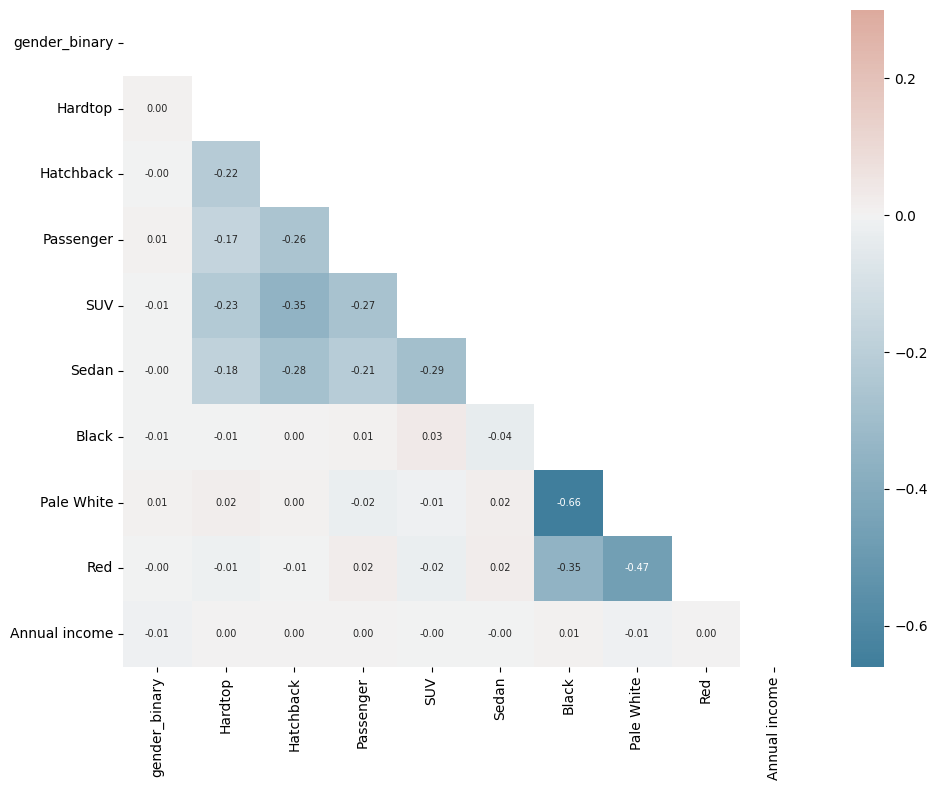

In [8]:
# Add conspiracy_binary as the first column in X to create a combined DataFrame YX
X['gender_binary'] = df['gender-binary']
YX = X[['gender_binary'] + [c for c in X.columns if c != 'gender_binary']]  # Ensure conspiracy_binary is the first column

# Calculate the Correlation Matrix
corr = YX.corr()

# Plotting
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt=".2f", annot_kws={"size": 7})
plt.tight_layout()
plt.show()

### Part b): Model Assessment and Selection

#### i. Set up the full design matrix X, this time include the states_matrix, and a constant. 
#### Finally bind the outcome to it and ensure it's the first column of the resulting dataframe. 

In [9]:
X = X[['Black', 'Hardtop', 'Passenger', 'SUV', 'Sedan', 'Hatchback']]
# Add a constant to the feature matrix for statsmodels
X_const = sm.add_constant(X)

# Get full dataset together 
YX_const = pd.concat([df['gender-binary'], X_const], axis = 1)

YX_const = YX_const.dropna(axis = 0)

#### ii. Create a validation set (75%) and test set (25%). 


In [10]:
# Split data into validation and test (75:25)

# Calculate 25% of the dataset size
num_samples = len(YX_const.sample(frac = 0.25, random_state = 42))

# Generate a list of all row IDs
# Assuming row IDs start at 0 and go up to dataset_size-1
row_ids = list(range(YX_const.shape[0]))

# Randomly select 25% of the row IDs
selected_row_ids = random.sample(row_ids, num_samples)

# Subset to create validation and test
YX_const_test = YX_const.iloc[YX_const.index.isin(selected_row_ids)] # the randomly chosen 25% goes to test-set
YX_const_val = YX_const.iloc[~YX_const.index.isin(selected_row_ids)] # the remaining 75% is our validation set

#### iii. Using a dictionary, define three candidate models in terms of the columns of the design matrix involved in each. 
#### The first model should be the homogeneous probability model; the second should have have all covariates except the states; the third should use all the columns. 


In [11]:
X_const = X_const.drop(7564)

In [12]:
# Define predictors for each model variant
predictors = {
    'a': ['const'],
    'b': [col for col in X_const.columns if (col not in body_style.columns.to_list())],
    'c': X_const.columns.tolist()
}

#### iv. Pick a metric (or more) on which you want to compare these models. Using cross-validation on the validation set, compare the models and select one you wish to deploy. 

In [13]:
y = YX_const_val['gender-binary'] # Target variable

# Define K for cross validation
K = 5

# Setup the KFold cross-validation
kf = KFold(n_splits=K, shuffle=True)

# Initialize a dictionary to store Brier scores
scores = {key: [] for key in predictors}


# Initialize dictionaries to store scores
brier_scores = {key: [] for key in predictors}
acc_scores = {key: [] for key in predictors}  
balanced_acc_scores = {key: [] for key in predictors}
aic_scores = {key: [] for key in predictors}  # AIC scores

for key, cols in predictors.items():
    
    for train_index, test_index in kf.split(YX_const_val):
        
        # Split into train and test according to the folds 
       
        X_train, X_test = YX_const_val.iloc[train_index][cols], YX_const_val.iloc[test_index][cols]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # For each fold split, fit the model
        model = sm.Logit(y_train, X_train).fit(disp=0)  # disp=0 suppresses the output
                
        # Predict probabilities
        y_pred_prob = model.predict(X_test)

        # Calculate Brier score
        brier_score = brier_score_loss(y_test, y_pred_prob)
        brier_scores[key].append(brier_score)

        # Convert probabilities to binary predictions (assume simple >0.5 probability as threshold)
        y_pred_binary = (y_pred_prob > 0.5).astype(int)

        # Calculate Accuracy Score
        acc_score = accuracy_score(y_test, y_pred_binary)
        acc_scores[key].append(acc_score)
        
        # Calculate Balanced Accuracy Score
        bal_acc_score = balanced_accuracy_score(y_test, y_pred_binary)
        balanced_acc_scores[key].append(bal_acc_score)
        
        # Store AIC
        aic_scores[key].append(model.aic)
        
        print(model.summary())
        
# Calculate and print the average scores
results = []
for key in predictors.keys():
    average_brier_score = np.mean(brier_scores[key])
    print(average_brier_score)
    average_bal_acc_score = np.mean(balanced_acc_scores[key])
    average_acc_score = np.mean(acc_scores[key])
    average_aic_score = np.mean(aic_scores[key])  # Calculate average AIC
    results.append({
        'Model': key,
        'Average Brier Score': average_brier_score,
        'Average Accuracy': average_acc_score,
        'Average Balanced Accuracy': average_bal_acc_score,
        'Average AIC': average_aic_score
    })

# Convert results to DataFrame for nicer display
results_df = pd.DataFrame(results)
results_df

                           Logit Regression Results                           
Dep. Variable:          gender-binary   No. Observations:                14343
Model:                          Logit   Df Residuals:                    14342
Method:                           MLE   Df Model:                            0
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:               4.030e-14
Time:                        11:33:54   Log-Likelihood:                -7445.2
converged:                       True   LL-Null:                       -7445.2
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3016      0.020    -63.919      0.000      -1.341      -1.262
                           Logit Regression Results                           
Dep. Variable:          gender-binary   No. Observat

c:\Users\majak\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:          gender-binary   No. Observations:                14343
Model:                          Logit   Df Residuals:                    14336
Method:                           MLE   Df Model:                            6
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:               0.0001879
Time:                        11:33:56   Log-Likelihood:                -7505.8
converged:                      False   LL-Null:                       -7507.2
Covariance Type:            nonrobust   LLR p-value:                    0.8309
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0639        nan        nan        nan         nan         nan
Black         -0.0103      0.044     -0.237      0.813      -0.096       0.075
Hardtop       -0.2263        nan        nan        n

,Model,Average Brier Score,Average Accuracy,Average Balanced Accuracy,Average AIC
0,a,0.16896,0.78471,0.50000,14944.23612
1,b,0.16897,0.78471,0.50000,14945.75257
2,c,0.16894,0.78471,0.50000,14949.48968


#### v. Re-fit the selected model to the full validation set. 

In [14]:
# Pick model B, in virtue of lower AIC 
# Now fit the model to the full validation set
model = sm.Logit(YX_const_val['const'], YX_const_val[predictors['a']]).fit()

         Current function value: 0.000000
         Iterations: 35


c:\Users\majak\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\majak\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\majak\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\majak\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\majak\anaconda3

In [15]:
# Get summary results
summary = model.summary()
print(summary)

                           Logit Regression Results                           
Dep. Variable:                  const   No. Observations:                17929
Model:                          Logit   Df Residuals:                    17928
Method:                           MLE   Df Model:                            0
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:                     inf
Time:                        11:33:57   Log-Likelihood:            -6.4150e-08
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.3562   3948.209      0.007      0.995   -7711.992    7764.704

Complete Separation: The results show that there iscomplete separation or perfect prediction.
In this case the Maximum Likelihood 

c:\Users\majak\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\majak\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\majak\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\majak\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\majak\anaconda3

### Part c): Model Evaluation and Estimation of Generalisation Error

#### i. Generate 1000 simulations of the regression coefficients by sampling from the empirical posterior distribution. 

In [16]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

#### ii.  For each simulation, generate a predicted probability for the test-set conspiracy assessments. 

In [17]:
# Initialize an array to store predictions from each simulation
predictions = np.zeros((n_simulations, YX_const_test.shape[0]))

# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    log_odds = np.dot(YX_const_test[predictors['a']], beta_simulation)
    probabilities = logistic_sigmoid(log_odds)  # Convert log-odds to probabilities
    predictions[i] = probabilities.flatten()

#### iii.  For the first 20 assessments in the test-set, plot the posterior distirbution of the probabilities.
#### Highlight whether the density of each lies above or below a given `threshold` for classification. 

In [18]:
predictions.shape

(1000, 5976)

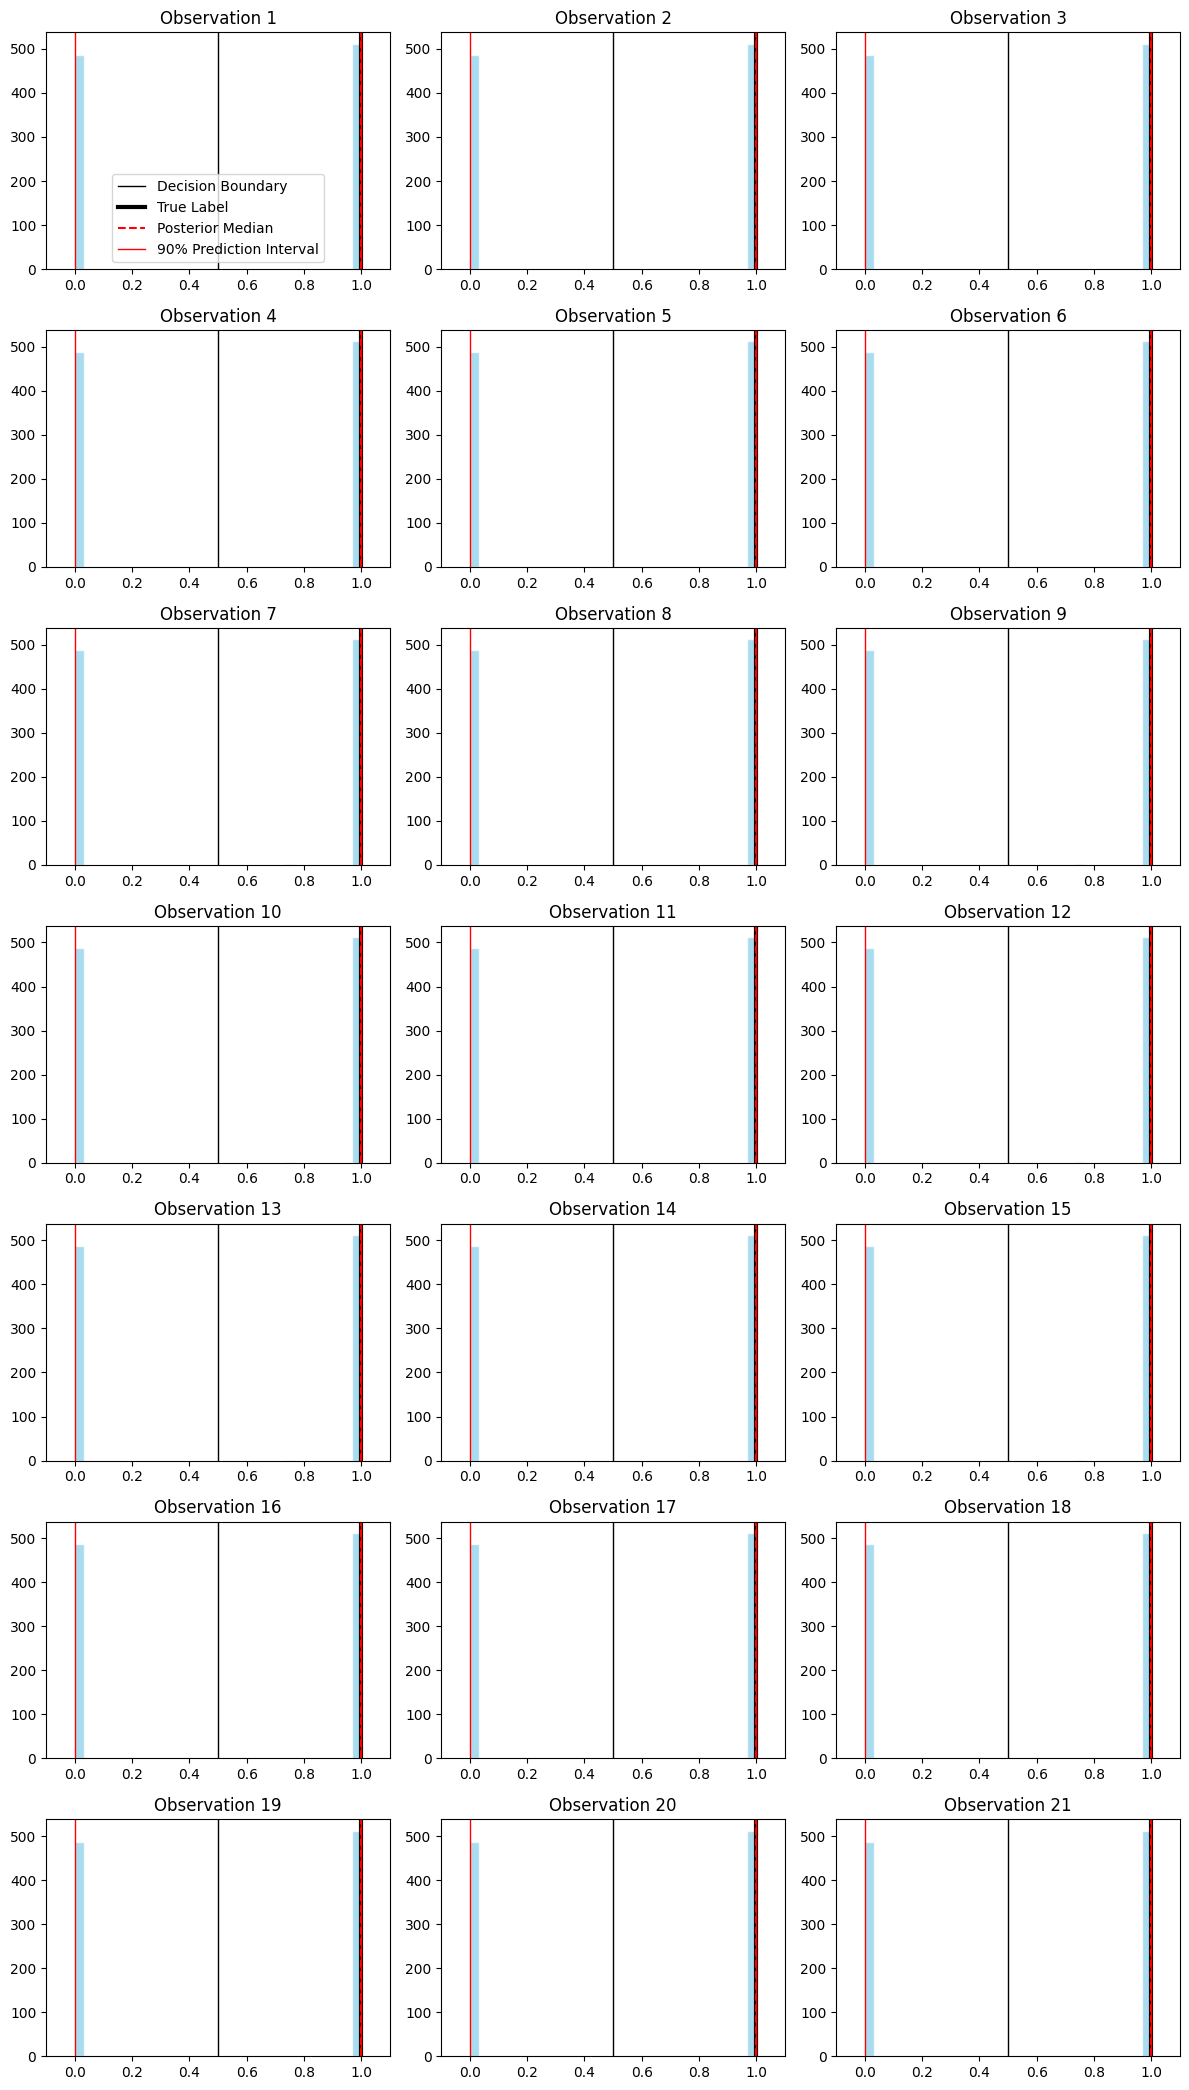

In [19]:
true_labels = YX_const_test['const']

# Calculate posterior median and the 90% prediction interval for each of the first 10 observations
posterior_medians = np.median(predictions, axis=0)
lower_bounds = np.percentile(predictions, 5, axis=0)
upper_bounds = np.percentile(predictions, 95, axis=0)

# Plotting with the adjustments for the 90% prediction interval to be shown with red lines
counts = [7,3] # 1 more than 20 because fuck you <- that was my boyfriend
fig, axes = plt.subplots(*counts, figsize=(counts[1]*4, counts[0]*3))

for i,ax in enumerate(axes.ravel()):
    # Histogram of simulated probabilities for observation i
    ax.hist(predictions[:, i], bins=30, color='skyblue', edgecolor='white', alpha=0.7)
    
    # Draw a line for the decision boundary 
    ax.axvline(x=0.5, color='black', linewidth=1, label='Decision Boundary')
    
    # Draw a thick solid black line at the true label position
    true_label_position = 0 if true_labels.iloc[i] == 0 else 1  # Determine the position based on the true label
    ax.axvline(x=true_label_position, color='black', linewidth=3, label='True Label')
    
    # Add posterior median
    ax.axvline(x=posterior_medians[i], color='red', linestyle='--', label='Posterior Median')
    
    # Marking the 90% prediction interval with red lines instead of shading
    ax.axvline(x=lower_bounds[i], color='red', linestyle='-', linewidth=1, label='90% Prediction Interval' if i == 0 else "")
    ax.axvline(x=upper_bounds[i], color='red', linestyle='-', linewidth=1)
    
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(f'Observation {i+1}')
    if i == 0:  # Add legend to the first subplot only to avoid repetition
        ax.legend()

plt.tight_layout()
plt.show()

#### v. Simulate classes (1s or 0s) from the posterior predictive distirbution. 

In [20]:
# Simulate from the posterior-predictive distirbution 
simulated_outcomes = np.random.binomial(1, predictions)

#### vi. The generalisation error for Classification. 



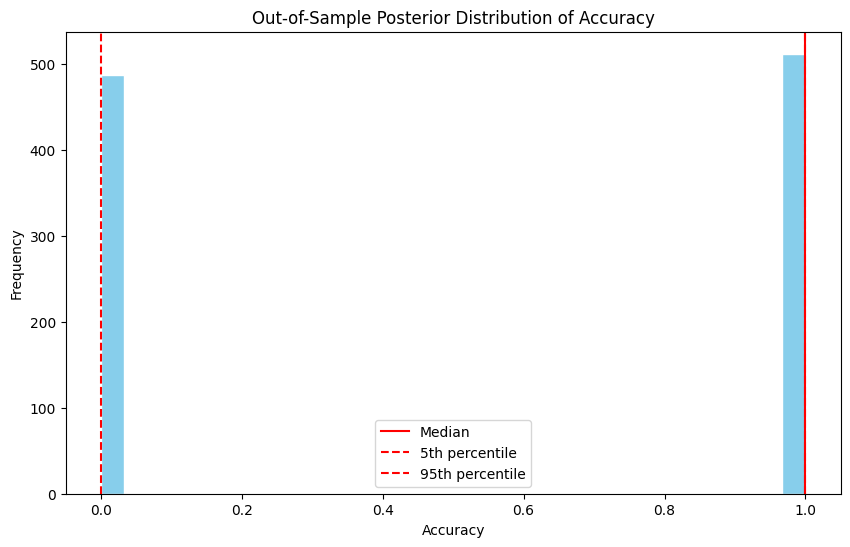

In [21]:
# Calculate accuracy for each simulation
accuracies = []
for i in range(n_simulations):
    accuracies.append(accuracy_score(true_labels, simulated_outcomes[i]))

# Plot the histogram of accuracies
plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=30, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(accuracies), color='red', label='Median')
plt.axvline(x=np.percentile(accuracies, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(accuracies, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of Accuracy')
plt.legend()
plt.show()